### Preprocessing
Preprocess the training data only, starting from the raw images stored in /medaka-img/src_files/train_2024-10-03

1. Create Dataset object to load in data:
    * Crop out bottom text
    * Within-image pixel intensity normalization
3. Plot histogram of all pixel values for all the images in the dataset
4. Determine which fish are left- vs right-facing (UMAP) and accordingly flip so all are right-facing
5. Generate image masks (threshold: > 15)
6. (VOTj alignment; do on FIJI desktop app)
7. (Visualization & validation of fish orientation; do on nepari desktop app)
8. Augment images with rotations [45 deg -> 135 deg]

Kernel: indigene-img

In [23]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)

from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')

### Define image transformations

In [6]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [7]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


#### Read in the dataframe which specifies whether the fish is left- or right-facing
Used to flip all left-facing images to the right within the MedakaDataset class

In [8]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

### Define a custom Dataset class for the medaka images

In [9]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
                
        image = ski.io.imread(img_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)
        
        return image, img_name

In [10]:
# Load datasets
train_dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)
print("n_train: ", len(train_dataset))

test_dataset = MedakaDataset(csv_file='test_set_2024-10-03.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)
print("n_test: ", len(test_dataset))

n_train:  1112
n_test:  1009


### Calculate mean, stdev of images
Maybe useful for later, if decide to do cross-dataset normalization rather than within-image normalization

In [46]:
### Second way of calculating mean and stdev
### mean = ([3.5028e-02, 5.2371e-05, 4.3022e-04]), std = ([0.0600, 0.0013, 0.0028])
### Taken from https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2
medaka_loader = DataLoader(train_dataset, batch_size=10, num_workers=0, shuffle=False)

mean = 0.0
for images, _ in medaka_loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(medaka_loader.dataset)

var = 0.0
for images, _ in medaka_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(medaka_loader.dataset)*980*1392))

print("Mean: ", mean)
print("Std: ", std)

Mean:  tensor([3.5028e-02, 5.2371e-05, 4.3022e-04])
Std:  tensor([0.0600, 0.0013, 0.0028])


In [65]:
## First way of calculating mean and stdev
## mean=(3.5028e-02, 5.2371e-05, 4.3022e-04), std=(0.0600, 0.0013, 0.0028)
## Taken from https://kozodoi.me/blog/20210308/compute-image-stats
medaka_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
pixel_values = []

# loop through images
for inputs, input_name in tqdm(list(islice(medaka_loader, 100))):
    psum += inputs.sum(axis=[0, 2, 3])
    psum_sq += (inputs**2).sum(axis=[0, 2, 3])
    pixel_values.extend(inputs[0].permute(1, 2, 0).numpy().ravel())

100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


In [19]:
# Final calculations
print("For the training dataset: ", str(len(train_dataset)))

print(psum)
print(psum_sq)

count = len(train_dataset) * 980 * 1392 # pixel count

total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

print("mean: " + str(total_mean))
print("std:  " + str(total_std))

For the training dataset:  1112
tensor([53135104.0000,    79444.6406,   652620.0000])
tensor([7.3246e+06, 2.6300e+03, 1.2057e+04])
mean: tensor([3.5028e-02, 5.2371e-05, 4.3022e-04])
std:  tensor([0.0600, 0.0013, 0.0028])


### Plot histogram

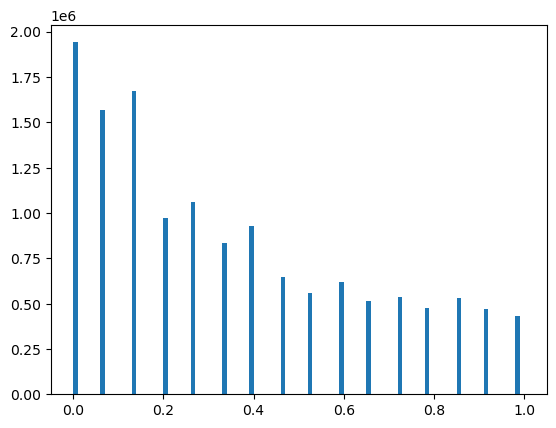

In [16]:
# Plotting histogram of pixel values
# Must run after normalizing the dataset with the mean, std values found in the cell below
# hist(np.array(pixel_values), bins=100, color='c', alpha=0.7, rwidth=0.85)
b, bins, patches = plt.hist(pixel_values, bins=100, range=(0,1))

### Show image normalization result and print pixel values (from subsample of 100 images)

0.0
1.0
PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_D6.tif


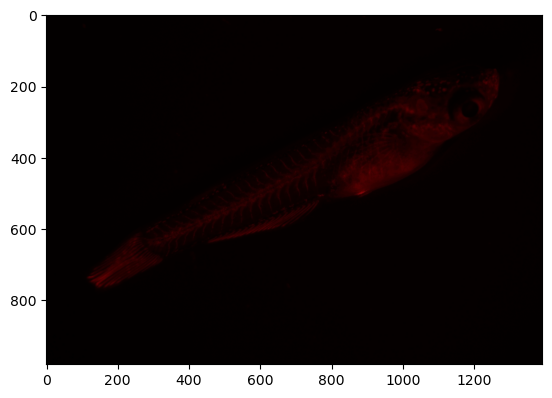

In [37]:
# For raw (unnormalized) images
print(min(pixel_values))
print(max(pixel_values))

train_example, train_example_name = train_dataset[500]
print(train_example_name)
plt.imshow(train_example.permute(1, 2, 0))

0.0
1.0
PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_D6.tif


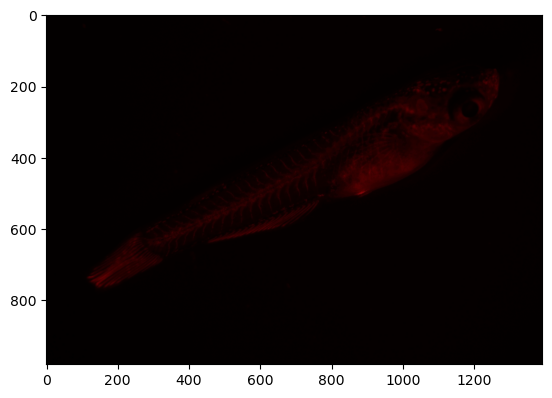

In [51]:
# For images normalized with mean (0, 0, 0) and (1, 1, 1)
print(min(pixel_values))
print(max(pixel_values))

train_example, train_example_name = train_dataset[500]
print(train_example_name)
plt.imshow(train_example.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.5838
431.33228
PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_D6.tif


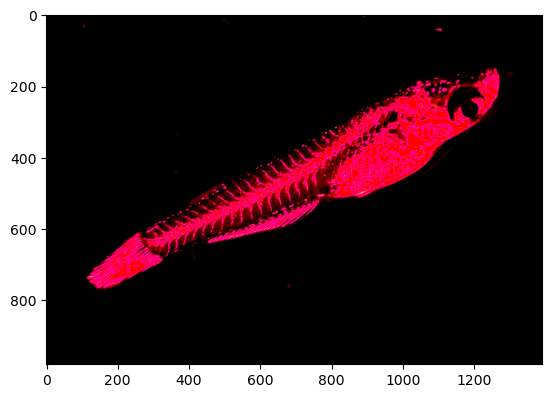

In [56]:
# For images normalized with mean (3.5028e-02, 5.2371e-05, 4.3022e-04) and std (0.0600, 0.0013, 0.0028)
# Maybe some issue with outlier pixel values
print(min(pixel_values))
print(max(pixel_values))

train_example, train_example_name = train_dataset[500]
print(train_example_name)
plt.imshow(train_example.permute(1, 2, 0))

-2.117904
2.2489083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_D6.tif


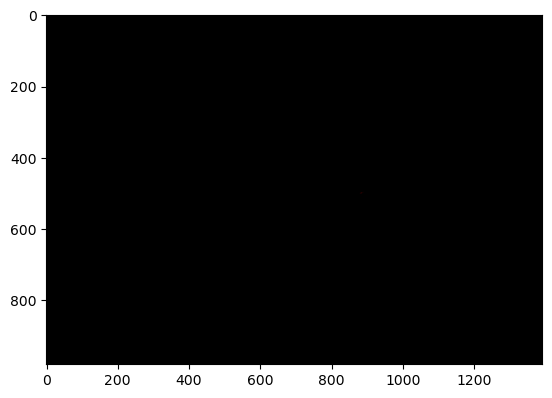

In [61]:
# For images normalized with imagenet mean and std
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
print(min(pixel_values))
print(max(pixel_values))

train_example, train_example_name = train_dataset[500]
print(train_example_name)
plt.imshow(train_example.permute(1, 2, 0))

0.0
1.0
PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_D6.tif


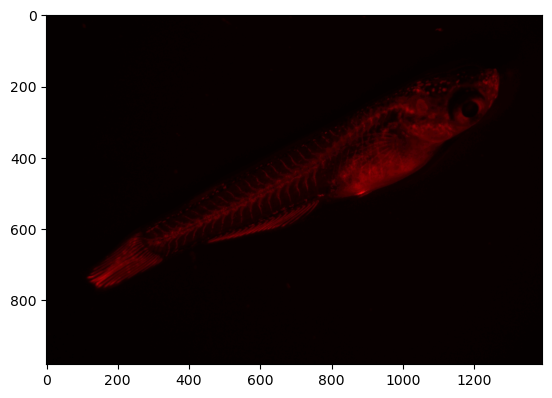

In [66]:
# Within-image normalization
print(min(pixel_values))
print(max(pixel_values))

train_example, train_example_name = train_dataset[500]
print(train_example_name)
plt.imshow(train_example.permute(1, 2, 0))

### Load single test image to visualize pipeline

In [14]:
train_example, train_example_name = train_dataset[393] # 393 for an originally right-facing image

In [15]:
train_example_name

'PLATE 14 F2 VC_ Female 95-1 F14 x Male 33-1 F14_B4.tif'

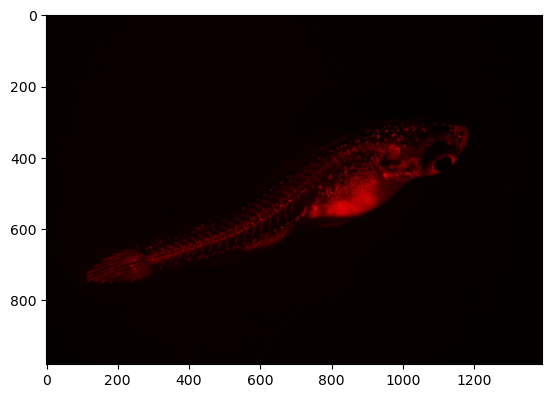

In [16]:
plt.imshow(train_example.permute(1, 2, 0)) # permute from (C, H, W) for tensor -> (H, W, C) for matplotlib

In [17]:
train_example.shape

torch.Size([3, 980, 1392])

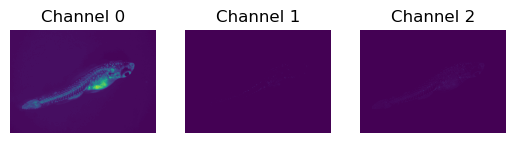

In [18]:
# Plot all three colour channels of the example image
fig, axs = plt.subplots(1,3)

for i in [0, 1, 2]:
    axs[i].imshow(train_example.permute(1, 2, 0)[:,:,i])
    axs[i].set_title('Channel ' + str(i))
    axs[i].axis('off')

plt.show()

torch.Size([980, 1392])
Min pixel value:  tensor(0.)
Max pixel value:  tensor(1.)


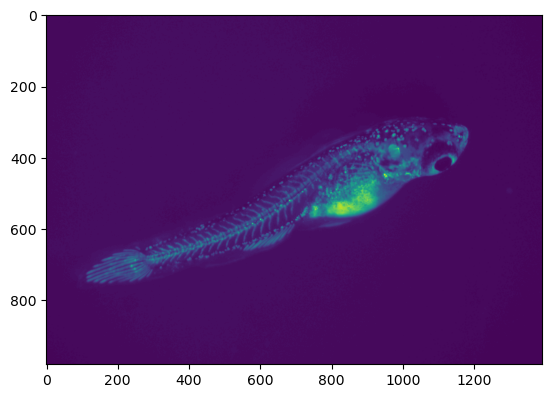

In [19]:
# Get the pixel values of the first channel of the example image
plt.imshow(train_example.permute(1, 2, 0)[:,:,0])

print(train_example.permute(1, 2, 0)[:,:,0].shape)
print("Min pixel value: ", torch.min(train_example.permute(1, 2, 0)[:,:,0]))
print("Max pixel value: ", torch.max(train_example.permute(1, 2, 0)[:,:,0]))

### Test RandomRotation
https://pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html

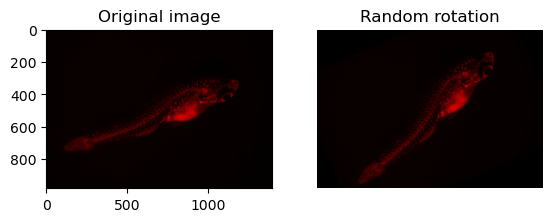

In [20]:
# Plot all three colour channels of the example image
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example.permute(1, 2, 0))
axs[0].set_title('Original image')

axs[1].imshow(transforms.RandomRotation(degrees=45)(train_example).permute(1, 2, 0))
axs[1].set_title('Random rotation')
axs[1].axis('off')

plt.show()

### Show a random subset of images to check if they are all right-facing

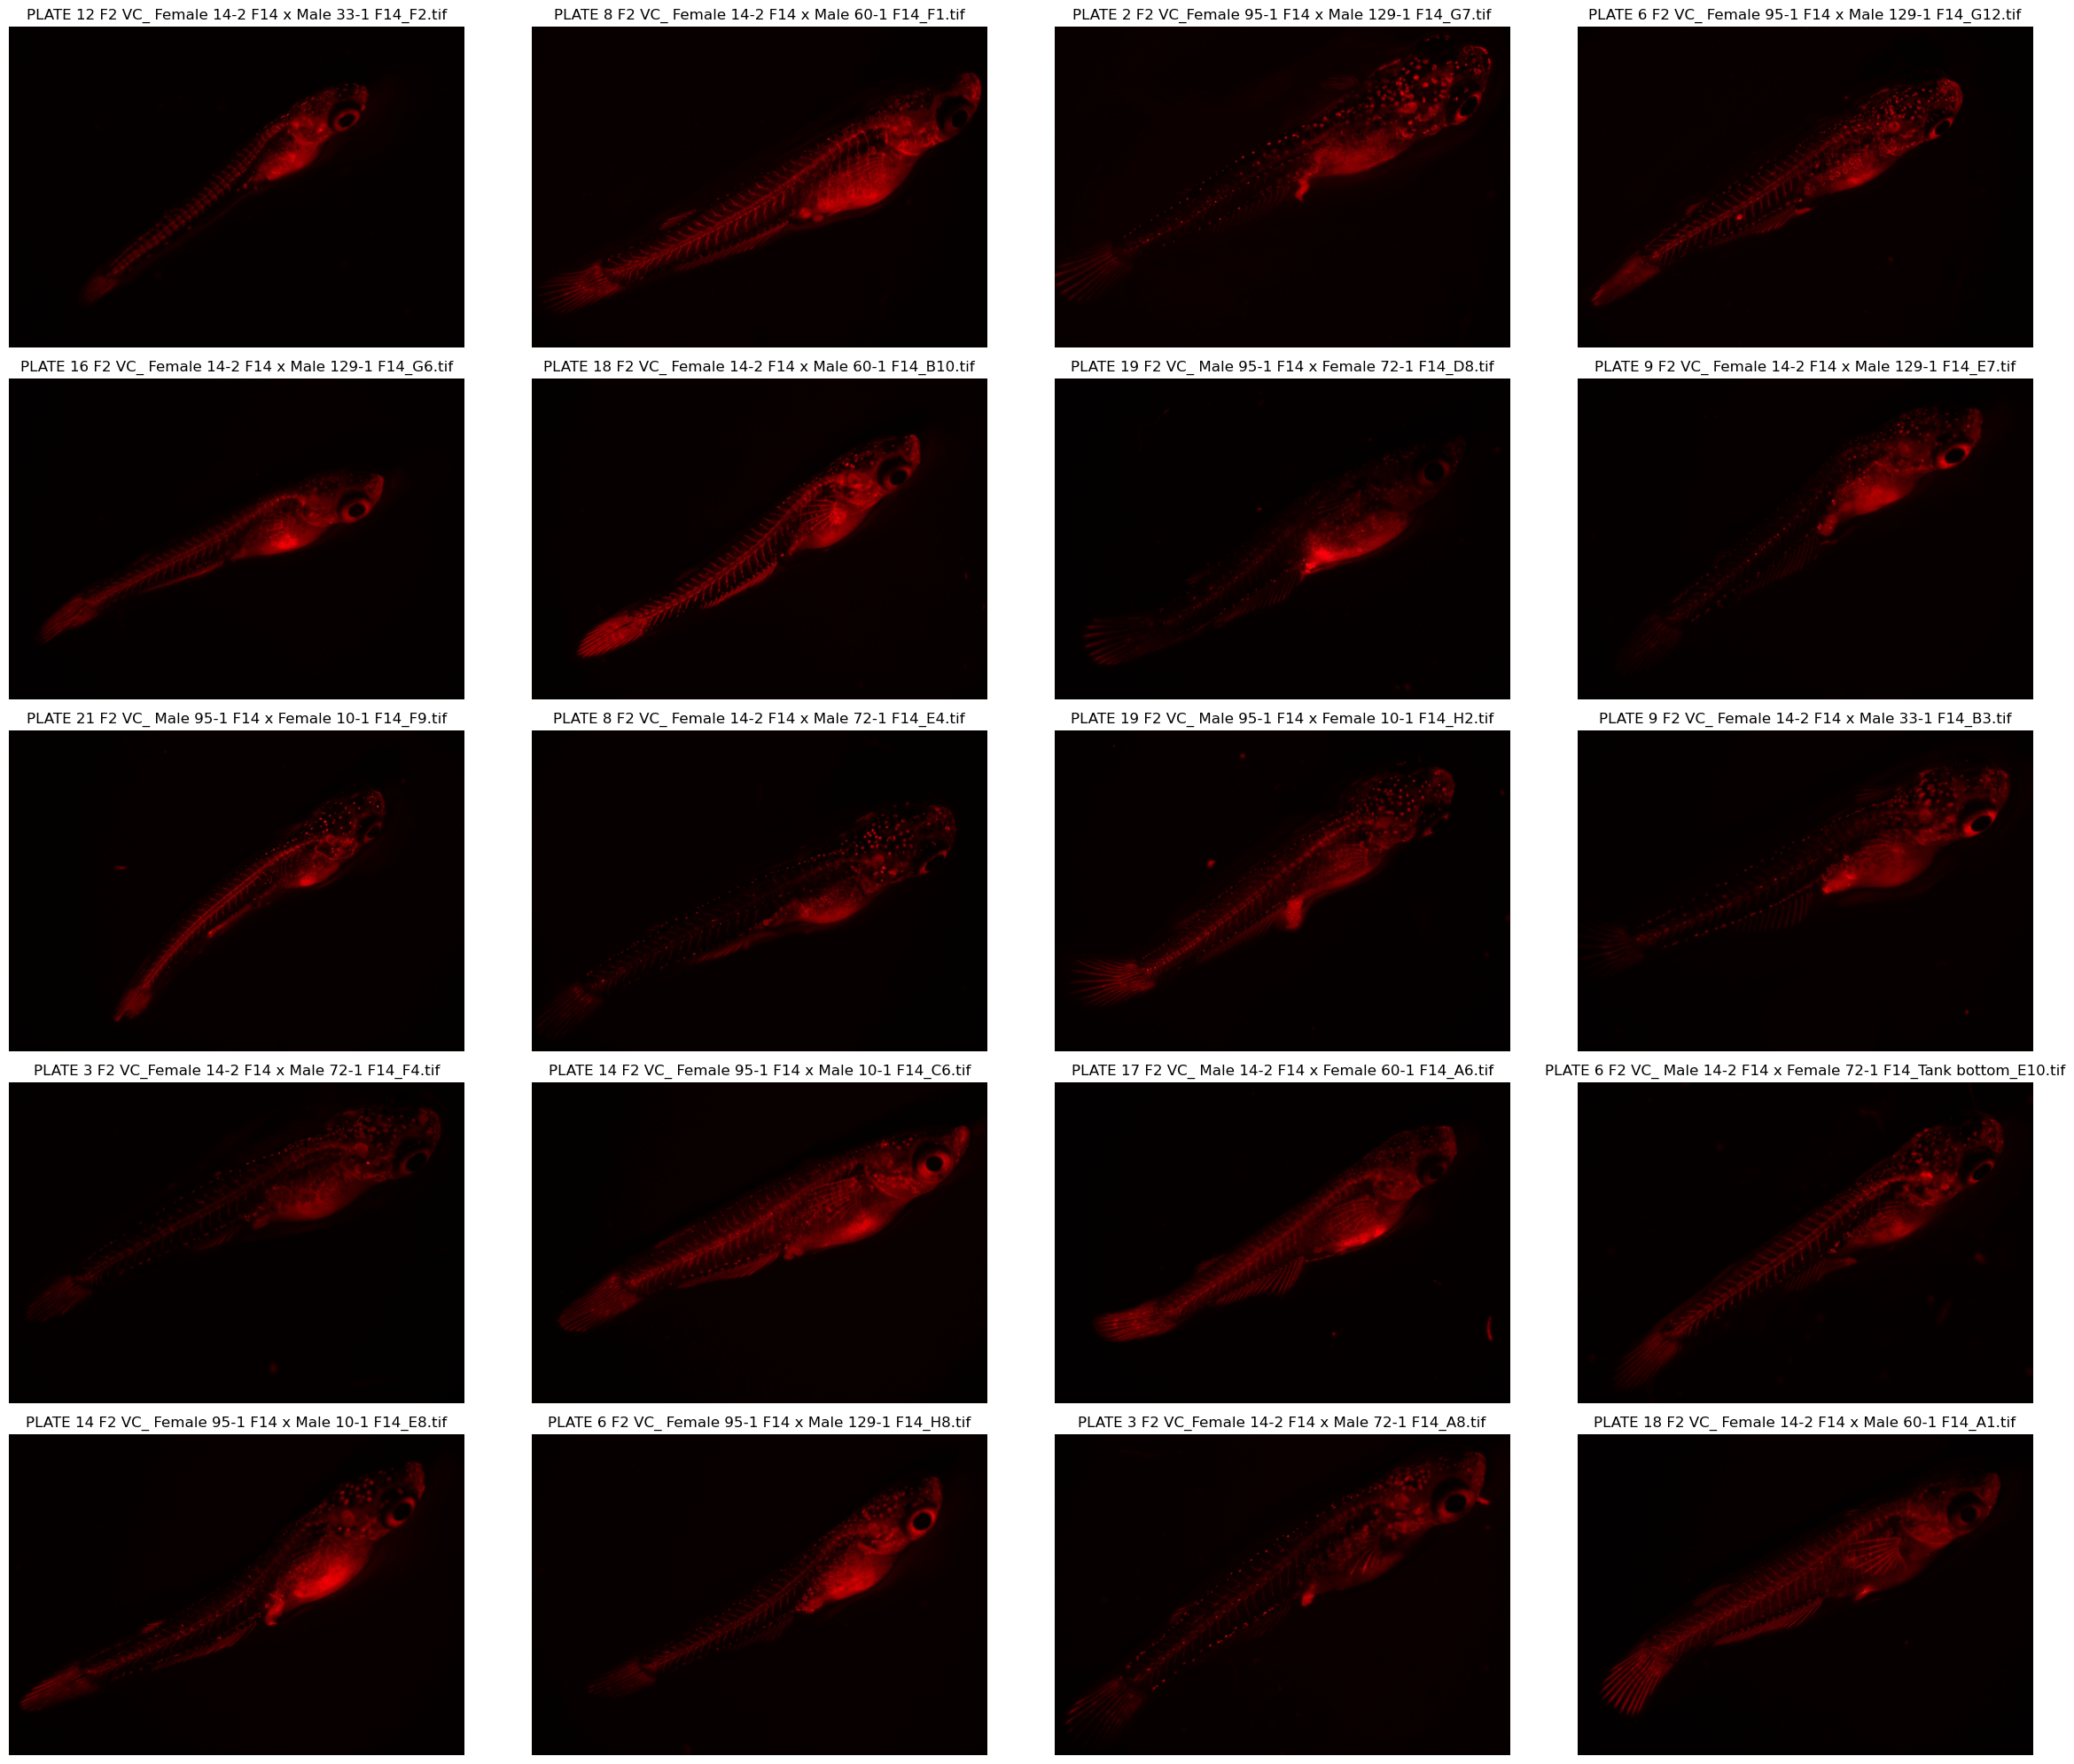

In [21]:
fig, axs = plt.subplots(5, 4, figsize=(25, 20), tight_layout=True)
for i, ax in enumerate(axs.flatten()):
    img, img_name = train_dataset[random.randint(0, len(train_dataset))]
    # img, img_name = train_dataset[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(img_name)
    ax.axis('off')

### Load and run MambaVision-T-1K model

In [24]:
model = AutoModel.from_pretrained("nvidia/MambaVision-T-1K", trust_remote_code=True)

# eval mode for inference
model.cuda().eval()

MambaVisionModel(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm

In [25]:
out_avg_pool, features = model(train_example.unsqueeze(0).cuda())
print("Size of the averaged pool features:", out_avg_pool.size())  # torch.Size([1, 640])
print("Number of stages in extracted features:", len(features)) # 4 stages
print("Size of extracted features in stage 1:", features[0].size()) # torch.Size([1, 80, 245, 348])
print("Size of extracted features in stage 2:", features[1].size()) # torch.Size([1, 160, 123, 174])
print("Size of extracted features in stage 3:", features[2].size()) # torch.Size([1, 320, 62, 87])
print("Size of extracted features in stage 4:", features[3].size()) # torch.Size([1, 640, 31, 44])

Size of the averaged pool features: torch.Size([1, 640])
Number of stages in extracted features: 4
Size of extracted features in stage 1: torch.Size([1, 80, 245, 348])
Size of extracted features in stage 2: torch.Size([1, 160, 123, 174])
Size of extracted features in stage 3: torch.Size([1, 320, 62, 87])
Size of extracted features in stage 4: torch.Size([1, 640, 31, 44])


In [67]:
# Create a feature matrix for the training dataset
feature_matrix = {}
medaka_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

for img, img_name in tqdm(medaka_loader):
    out_avg_pool, features = model(img[0].unsqueeze(0).cuda())
    feature_matrix[img_name[0]] = out_avg_pool.cpu().detach()[0].numpy()

100%|██████████| 1112/1112 [00:32<00:00, 33.97it/s]


In [68]:
feature_matrix_df = pd.DataFrame.from_dict(feature_matrix, orient='index')
feature_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif,0.082199,-0.012071,0.143951,0.134496,-0.033668,0.026754,-0.205183,-0.099103,0.178533,0.062986,...,0.098944,0.177855,0.009408,-0.312457,0.120044,0.029208,0.161382,-0.076307,-0.089762,-0.135751
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A10.tif,0.099899,0.006491,0.138202,0.101388,-0.046534,-0.021978,-0.184308,-0.100441,0.206886,0.053064,...,0.052109,0.193592,0.037213,-0.340455,0.132186,0.028464,0.170160,-0.087419,-0.061568,-0.147154
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A12.tif,0.111073,0.012264,0.117461,0.117448,-0.058538,-0.034507,-0.192980,-0.102137,0.159489,0.082466,...,0.062787,0.155960,0.024751,-0.324856,0.133028,0.002279,0.167416,-0.079487,-0.061059,-0.122677
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04.tif,0.091251,0.021017,0.139876,0.140953,-0.083661,0.005025,-0.179184,-0.067198,0.204301,0.046446,...,0.031123,0.159955,0.050132,-0.344304,0.079153,-0.030138,0.140670,-0.135698,-0.062942,-0.124546
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A08.tif,0.111446,0.017437,0.127534,0.136579,-0.040341,-0.018649,-0.201578,-0.078134,0.191840,0.088185,...,0.044501,0.168034,0.017614,-0.322081,0.108311,-0.009832,0.167742,-0.089328,-0.065121,-0.101483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_C9.tif,0.116730,0.013715,0.136968,0.123555,-0.059240,-0.015717,-0.177494,-0.084650,0.191203,0.102285,...,0.068185,0.149930,0.037268,-0.305845,0.114659,0.014118,0.176101,-0.088555,-0.044406,-0.132623
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D2.tif,0.093224,0.031676,0.126870,0.123358,-0.088231,-0.031649,-0.219481,-0.115434,0.191922,0.113316,...,0.063959,0.172204,0.028673,-0.296650,0.133243,-0.025576,0.150370,-0.062662,-0.039751,-0.117833
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D3.tif,0.108317,0.048427,0.126162,0.102220,-0.083566,-0.024956,-0.185351,-0.111585,0.199557,0.097471,...,0.081409,0.141296,-0.014397,-0.306957,0.091677,0.000325,0.174791,-0.067722,-0.027278,-0.092019
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D5.tif,0.114529,0.023052,0.125887,0.117461,-0.046072,-0.030702,-0.167896,-0.079699,0.212803,0.059673,...,0.044729,0.146676,0.018344,-0.310671,0.114020,0.015726,0.165626,-0.121753,-0.073646,-0.107558


In [69]:
feature_matrix_df.to_csv('feature_matrix_train_set_2024-10-03_MambaVision-T-1K.csv')